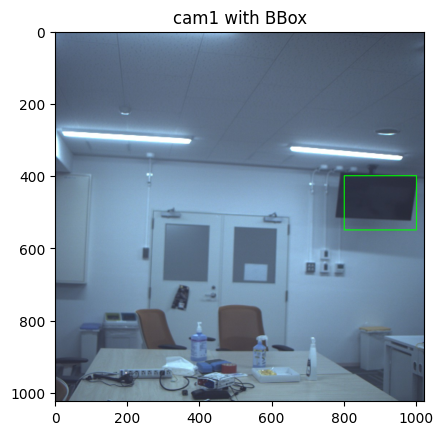

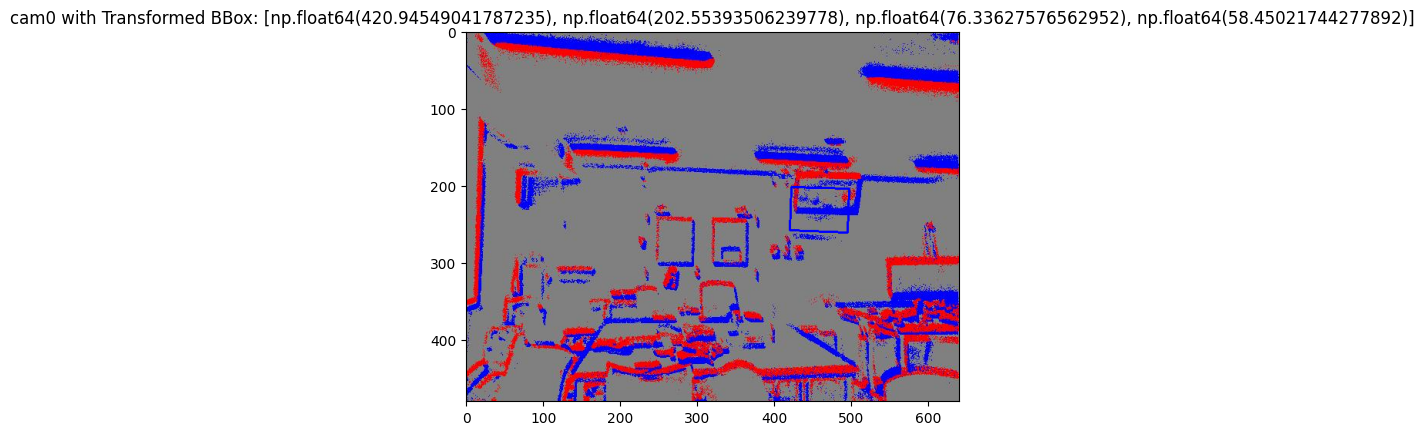

In [3]:
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt

# YAMLファイルを読み込む
def load_calibration(yaml_file):
    with open(yaml_file, 'r') as f:
        calib = yaml.safe_load(f)
    return calib

# BBoxを画像に描画
def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    for i in range(len(bbox)):
        start_point = tuple(map(int, bbox[i]))
        end_point = tuple(map(int, bbox[(i + 1) % len(bbox)]))
        cv2.line(image, start_point, end_point, color, thickness)
    return image

# 四隅形式 → [x, y, w, h]形式への変換
def corners_to_xywh(corners):
    x_min = min([pt[0] for pt in corners])
    y_min = min([pt[1] for pt in corners])
    x_max = max([pt[0] for pt in corners])
    y_max = max([pt[1] for pt in corners])
    return [x_min, y_min, x_max - x_min, y_max - y_min]

# [x, y, w, h]形式 → 四隅形式への変換
def xywh_to_corners(xywh):
    x, y, w, h = xywh
    return [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]

# ホモグラフィ行列を計算
def compute_homography(K0, K1, R, t, n, d):
    # nを縦ベクトルとして明示的に指定
    n = n.reshape(3, 1)  # (3,) -> (3, 1)
    # ホモグラフィ行列の計算
    H = K0 @ (R - (t @ n.T) / d) @ np.linalg.inv(K1)
    return H


# 同次座標を通常座標に変換
def homogeneous_to_cartesian(points):
    return points[:2] / points[2]

# メイン処理
def main(cam0_image_path, cam1_image_path, yaml_file, bbox_cam1_xywh):
    # 入力データの読み込み
    calib = load_calibration(yaml_file)

    # 画像読み込み
    cam0_img = cv2.imread(cam0_image_path)
    cam1_img = cv2.imread(cam1_image_path)

    if cam0_img is None or cam1_img is None:
        print("Error: Could not load images. Check file paths.")
        return

    # キャリブレーションパラメータの取得
    K0 = np.array([
        [calib['cam0']['intrinsics'][0], 0, calib['cam0']['intrinsics'][2]],
        [0, calib['cam0']['intrinsics'][1], calib['cam0']['intrinsics'][3]],
        [0, 0, 1]
    ])
    K1 = np.array([
        [calib['cam1']['intrinsics'][0], 0, calib['cam1']['intrinsics'][2]],
        [0, calib['cam1']['intrinsics'][1], calib['cam1']['intrinsics'][3]],
        [0, 0, 1]
    ])
    R = np.array(calib['cam1']['T_cn_cnm1'])[:3, :3]
    t = np.array(calib['cam1']['T_cn_cnm1'])[:3, 3].reshape(3, 1)
    n = np.array([0, 0, 1])  # 仮の法線ベクトル
    d = 2.0  # 仮の距離

    # bbox_cam1_xywhを四隅形式に変換
    bbox_cam1 = xywh_to_corners(bbox_cam1_xywh)

    # cam1のBBoxを描画して確認
    cam1_img_with_bbox = cam1_img.copy()
    cam1_img_with_bbox = draw_bbox(cam1_img_with_bbox, bbox_cam1, color=(0, 255, 0))
    plt.imshow(cv2.cvtColor(cam1_img_with_bbox, cv2.COLOR_BGR2RGB))
    plt.title("cam1 with BBox")
    plt.show()

    # ホモグラフィ行列の計算
    H = compute_homography(K0, K1, R, t, n, d)

    # BBoxをcam0座標に変換
    bbox_cam1_homogeneous = np.array([[x, y, 1] for x, y in bbox_cam1]).T
    bbox_cam0_homogeneous = H @ bbox_cam1_homogeneous
    bbox_cam0 = homogeneous_to_cartesian(bbox_cam0_homogeneous).T

    # bbox_cam0を[x, y, w, h]形式に変換
    bbox_cam0_xywh = corners_to_xywh(bbox_cam0)

    # cam0の画像にBBoxを描画
    cam0_img_with_bbox = cam0_img.copy()
    cam0_img_with_bbox = draw_bbox(cam0_img_with_bbox, bbox_cam0, color=(255, 0, 0))
    plt.imshow(cv2.cvtColor(cam0_img_with_bbox, cv2.COLOR_BGR2RGB))
    plt.title(f"cam0 with Transformed BBox: {bbox_cam0_xywh}")
    plt.show()

# 実行部分
cam0_image_path = '../../../data/event_image_30ms.jpg'  # cam0の画像パス
cam1_image_path = '../../../data/calibration/sample_record/images/frame_20241222_044954_169717.jpg'  # cam1の画像パス
yaml_file = '../../../data/calibration/kalibr_result/camchain-calibawsome.yaml'  # キャリブレーションファイルのパス
bbox_cam1_xywh = [800, 400, 200, 150]  # cam1のBBox座標 (x, y, w, h)

main(cam0_image_path, cam1_image_path, yaml_file, bbox_cam1_xywh)
